# Visualize data from the Streaming Analytics service using PixieDust

You can follow the steps and code in this Python notebook to create a simple Python Streams application that runs on the Streaming Analytics service on IBM Bluemix. 
You then connect to the service to retrieve the data and visualize it using PixieDust.

The setting is a call center for an airline.  The goal is to visualize a stream of customer complaints in real time and see which categories account for the most complaints.

Familiarity with Python and Jupyter Notebooks is recommended. This notebook runs on **Python 3.5.**

## Table of contents
***
1.	[Setup](#setup)
2.  [Create a Python application](#create_data)
1.	[View the data with PixieDust](#visualize)
1.	[Problem statement](#summary)
5.  [Stop the application](#stop)
***

<a id="setup"></a>
### 1.1 Start the Streaming Analytics service

Open the Bluemix web portal and <a href="https://console.ng.bluemix.net/" target="_blank" rel="noopener noreferrer">log in or sign up for a free Bluemix account</a>.

Ensure that your Streaming Analytics service is running in IBM Bluemix.

**If you don’t have a service,** you can create one as follows:  
1. Click **Catalog** or **Create Service**, browse for the `Streaming Analytics` and then click on it. <br>
1. Follow the instructions on the  Streaming Analytics catalog page, type the *Service name* to set up your service.
<img src='https://github.com/orzade/streamsx-notebooks/blob/master/servicename.png?raw=true' alt="Type your service name and click on Create" title="Streaming Analytics catalog - Type your service name"></img><br>
1. Click **Create** to open the Streaming Analytics service dashboard.<br> Your service starts automatically.

<a id="access"></a>
### 1.2 Set up access to the service

Before you create an app with this notebook, you must first provide the information that your streaming app needs to access the service. You can find this information on the Streaming Analytics service dashboard. It includes the service name, the service credentials, and the connection URL for the service. 
In the next cell you have to enter your service credentials. To copy your service credentials, open the Streaming Analytics service dashboard click **Service Credentials**, then **View Credentials**, and finally click the Copy icon.

<img src='https://github.com/orzade/streamsx-notebooks/blob/master/copyservicecredentials.png?raw=true' alt="Copy your service credentials" title="Streaming Analytics catalog - Copy your service credentials"></img>
Then paste those credentials where indicated in the cell below.


In [7]:
import json


def get_sa_credentials():
    #Paste the credentials you got from the screenshot above here
    credentials = {}
    
    """ #should look like this:
      credentials = {  "password": "212358pp8",
      "rest_port": "443",
      "bundles_path": "/jax-rs/bundles/service_instances/abcdef",
      "resources_path": "/jax-rs/resources/service_instances/abcdef",
      "stop_path": "/jax-rs/streams/stop/service_instances/",
      "rest_host": "streams-app-service.ng.bluemix.net",
      "size_path": "/jax-rs/streams/size/abcdef",
      "jobs_path": "/jax-rs/j....",
      "start_path": "/jax-rs/strea......22f",
      "rest_url": "https://streams-app-service.ng.bluemix.net",
      "userid": "abcdef",
      "status_path": "xxxxxx41cc22f"
      }
    """
    return json.dumps(credentials)

def get_service_name():
    return "service_name" #Change this to your service name..so in our screenshot above it would be "test1"

#authenticate and connect using credenetials above
def do_auth():
    _creds = get_sa_credentials()
    service_name = get_service_name()
    vs={'streaming-analytics': [{'name': service_name, 'credentials': json.loads (_creds)}]}
    cfg = {}
    cfg[ConfigParams.VCAP_SERVICES] = vs
    cfg[ConfigParams.SERVICE_NAME] = service_name
   
    return cfg
#submit job to service
def submit_to_service(topo): 
    cfg = do_auth()
    rc = submit('STREAMING_ANALYTICS_SERVICE', topo, cfg)
    return rc

<a id="create_data"></a>
# 2. Create the streams application

Run the following cell to create the Python application that generates data.  The application is submitted to the Streaming Analytics service.  Every time you run the cell it creates a new job, so you only need to run this cell once unless you restart the kernel.

In [6]:
from streamsx.topology.topology import Topology
from streamsx.topology.context import *
from streamsx.rest import StreamingAnalyticsConnection
from streamsx.topology import schema
import random
import json
import math




def generate_data():
    categories = ["Punctuality","Safety","Ticketing","Food","Luggage","Customer Service"]
    while True:
        value =  random.random() * 100
        index = math.floor(random.random() * 5 )
        payload = {"n_complaints" : value, "category" : categories[index]} 
        yield payload
    
topo = Topology('Complaints')
#data source is generated but could easily be from MQTT/Kafka etc
data_stream = topo.source(generate_data) 
#use a filter to only see categories with more than 10 complaints
filtered = data_stream.filter(lambda tuple : tuple["n_complaints"] > 10)
#create a view on that filtered stream
filtered.print()
complaints = filtered.view()


#submit the job to the Streaming Analytics service
result = submit_to_service(topo)
print("Submitted job to the service")




Jul 13, 2017 11:33:10 AM com.ibm.streamsx.topology.internal.context.remote.BuildServiceRemoteRESTWrapper remoteBuildAndSubmit
INFO: Streaming Analytics service (service_name): Checking status
Jul 13, 2017 11:33:13 AM com.ibm.streamsx.topology.internal.streaminganalytics.RestUtils checkInstanceStatus
INFO: Streaming Analytics service (service_name): instance status response:{"state":"STARTED","plan":"Standard","enabled":true,"status":"running"}
Jul 13, 2017 11:33:13 AM com.ibm.streamsx.topology.internal.context.remote.BuildServiceRemoteRESTWrapper remoteBuildAndSubmit
INFO: Streaming Analytics service (service_name): submitting build Complaints_7C08BFE79F5A5642
Jul 13, 2017 11:33:55 AM com.ibm.streamsx.topology.internal.context.remote.BuildServiceRemoteRESTWrapper remoteBuildAndSubmit
INFO: Streaming Analytics service (service_name): submitting job request.
Jul 13, 2017 11:34:03 AM com.ibm.streamsx.topology.internal.context.remote.BuildServiceRemoteRESTWrapper doSubmitJobFromBuildArtifa

<a id="visualize"></a>
# 3. Visualize the data in PixieDust

Create a pie chart to visualize the distribution of purchases. When you run the cell, the default display will be a table.

To create a pie chart:
- Select the chart option, choose "Pie Chart".
- Set Keys to "Category" and "Values" to "n_complaints".
- Under "Aggregation", select "Count" and enter 500.


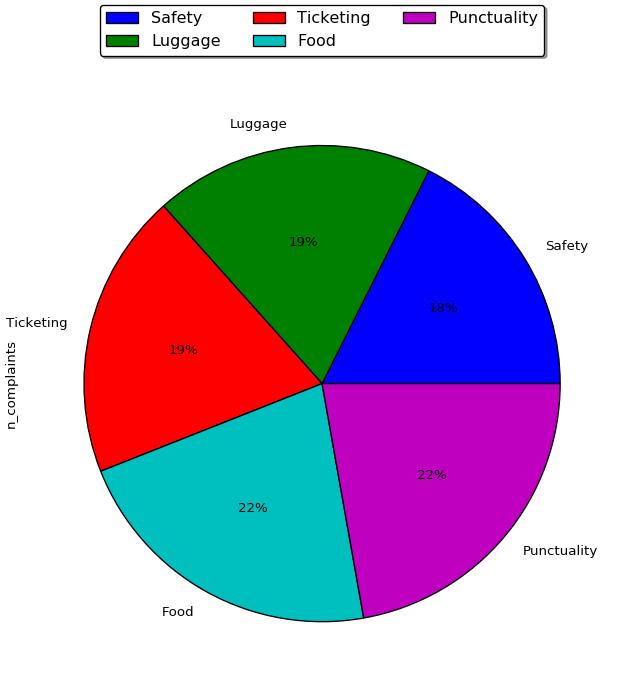

In [61]:
import time
import pandas
import pixiedust

#get data from the service 
def get_latest_batch():
    list_items = []
    queue = complaints.start_data_fetch()
    #print ("Fetching data from view")
    for i in range(500): #just get the last 500 complaints for now, but queue.get is a potentially infinite stream
       val = queue.get()
       list_items.append(val)
    return list_items


list_items = get_latest_batch()
buffer = json.dumps(list_items)
pandas_df = pandas.DataFrame(data=json.loads(buffer))
display(pandas_df)



    


<a id="summary"></a>
# 4. Problem

The stream of data is potentially infinite.  It would be nice if the graph was refreshed periodically, but there's no way to refresh the data with PixieDust. I have to re-run the above cell periodically to refresh the data.


<a id="stop"></a>
# 5. Stop the application
Run this cell to cancel the application, otherwise it runs indefinitely, consuming resources in your service. If you run this cell you need to re-run cell #2 to [generate data for the chart](#create_data)

In [64]:
job = result.job
if job.cancel():
    print("Cancelled the job. Re-run step 2 to start generating data again.")

ValueError: No resource matching: 44

Copyright © 2017 IBM. This notebook and its source code are released under the terms of the MIT License.